

```
# This is formatted as code
```

#Time Series Prediction: Exponential Smoothing

In this notebook, we use the library `statsmodels` of Python to estimate different version of Exponential smoothing models, analyze the fit of the models and make forecasts.

The example uses data from customer traffic to a retail store.

First, we load the relevant libraries, including `pandas` to manage datasets, and the dataset. Make sure to adapt the path when running on your own.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Load data into a pandas dataframe
# Change the path as needed

data = pd.read_csv("traffic_day_small.csv")


# 2. Drop unnecessary columns
data.drop(columns=['Exit', 'empresa'], inplace=True)

# 3. Convert 'datef' to a datetime format
data['datef'] = pd.to_datetime(data['datef'])

# 4. Filter out data prior to January 15, 2016
data_filtered = data[(data['datef'] >= '2016-01-15')  ].copy()

# Removing rows where 'Entry' column has a value of 0. These are holidays.
#data_filtered = data_filtered[data_filtered['Entry'] != 0]

# Creating a new column for the day of the week (0 = Monday, 6 = Sunday)
data_filtered['day_of_week'] = data_filtered['datef'].dt.dayofweek

# 5. (Optional) Display or save the cleaned data
print(data_filtered.head())

    tienda      datef  Entry    ciudad  precip  day_of_week
7        1 2016-01-15    174  santiago       0            4
8        1 2016-01-16    374  santiago       0            5
9        1 2016-01-17    244  santiago       0            6
10       1 2016-01-18    134  santiago       0            0
11       1 2016-01-19    139  santiago       0            1


 We use the  `Entry` column which has the number of customer entering the store each day.

In [2]:
# Describe the dataset

# Print the first few rows of the dataframe
print("First few rows of the dataframe:")
print(data.head())

# Print the number of rows and columns in the dataframe
print("Number of rows and columns in the dataframe:")
print(data.shape)

# Print the data types of the columns in the dataframe
print("Data types of the columns in the dataframe:")
print(data.dtypes)

First few rows of the dataframe:
   tienda      datef  Entry    ciudad  precip
0       1 2016-01-08    167  santiago       0
1       1 2016-01-09    382  santiago       0
2       1 2016-01-10    298  santiago       0
3       1 2016-01-11    133  santiago       0
4       1 2016-01-12    195  santiago       0
Number of rows and columns in the dataframe:
(711, 5)
Data types of the columns in the dataframe:
tienda             int64
datef     datetime64[ns]
Entry              int64
ciudad            object
precip             int64
dtype: object


In [3]:
# Summarize the data by store
grouped_df = data.groupby('tienda')
extended_summary = grouped_df.agg(
    days_count=('datef', 'count'),
    mean_entry=('Entry', 'mean'),
    std_entry=('Entry', 'std'),
    missing_values=('Entry', 'sum'),  # This will be corrected
    first_date=('datef', 'min'),
    last_date=('datef', 'max')
)

# Correcting the missing values calculation (count of missing values instead of sum)
extended_summary['missing_values'] = data.groupby('tienda')['Entry'].apply(lambda x: x.isnull().sum())

# Display the extended summary
print(extended_summary.head())

        days_count  mean_entry   std_entry  missing_values first_date  \
tienda                                                                  
1              358  310.837989  235.557522               0 2016-01-01   
2              353  427.184136  203.692763               0 2016-01-01   

        last_date  
tienda             
1      2016-12-31  
2      2016-12-31  


We will focus the analysis on Store 1, for dates from January 15 to October 20 (no missing dates in that range).

In [4]:
# Filter data
# Filtering data for store 1 and the specified date range
filtered_data = data[(data['tienda'] == 1) & (data['datef'] >= '2016-01-10') &
                                    (data['datef'] <= '2016-10-20')]
# create the time series data
ts_data = filtered_data.set_index('datef')['Entry']

print(ts_data.head(10))




datef
2016-01-10    298
2016-01-11    133
2016-01-12    195
2016-01-13    164
2016-01-14    150
2016-01-15    174
2016-01-16    374
2016-01-17    244
2016-01-18    134
2016-01-19    139
Name: Entry, dtype: int64


Graph the selected time series data

In [5]:
# Fill in missing dates
# Create a complete date range
date_range = pd.date_range(start='2016-01-10', end='2016-10-20')

# Reindex the store_1_timeseries to include all dates in the range, filling missing values with 0
ts_data_fill = ts_data.reindex(date_range, fill_value=0)


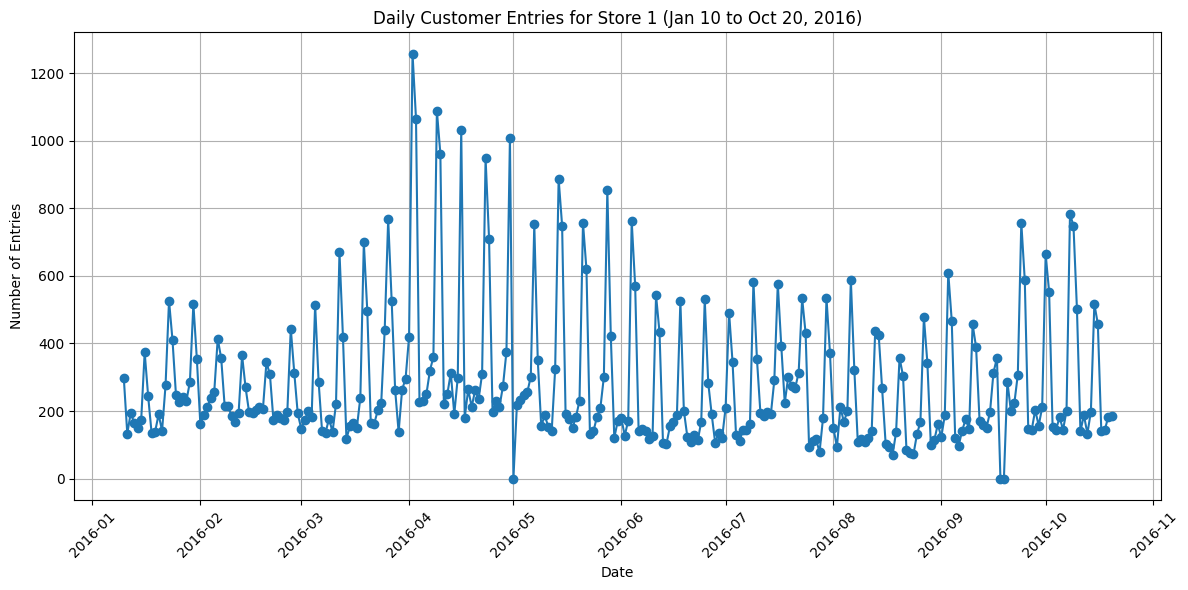

In [6]:
import matplotlib.pyplot as plt

# Assuming store_1_timeseries is already defined as per previous steps
# Plotting the timeseries data
plt.figure(figsize=(12, 6))
plt.plot(ts_data_fill, marker='o', linestyle='-')
plt.title('Daily Customer Entries for Store 1 (Jan 10 to Oct 20, 2016)')
plt.xlabel('Date')
plt.ylabel('Number of Entries')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

## Model Estimation - Moving Average

We consider the  Exponential Smoothing model, without seasonality nor *trend*.

The model is trained with data up to September and used to predict from Oct 1 to 20. The predictions are stores in the series  `forecast`.

In [7]:
# Load model packages
#from statsmodels.tsa.holtwinters import ExponentialSmoothing
#from statsmodels.tsa import ExponentialSmoothing

import statsmodels.api as sm

# End of September date
end_of_september = '2016-09-30'

# Splitting the data
train_data = ts_data_fill[:end_of_september]

In [8]:
# Run the model
# Specify the parameters for the exponential smoothing model
smoothing_level = 0.4

# Fit an exponential smoothing model to the data
model = sm.tsa.ExponentialSmoothing(train_data)
fit_model = model.fit(smoothing_level=smoothing_level)
#fit_model = model.fit()

# Generate predictions for the next 21 days
forecast = fit_model.forecast(steps=20)

# Print the forecasted values
#print(forecast)


We calculate the fitted value of the model for each observation and the corresponding *residual*, defined as the difference between the real and fitted value.

In [9]:
# Get the fitted values in Series format
fitted_values = fit_model.fittedvalues
# Get actual values in Series format
actual_values = data['Entry']

residual = actual_values - fitted_values




### Model Fit

We visualize the predictions vs the actual data in a time-series graph.

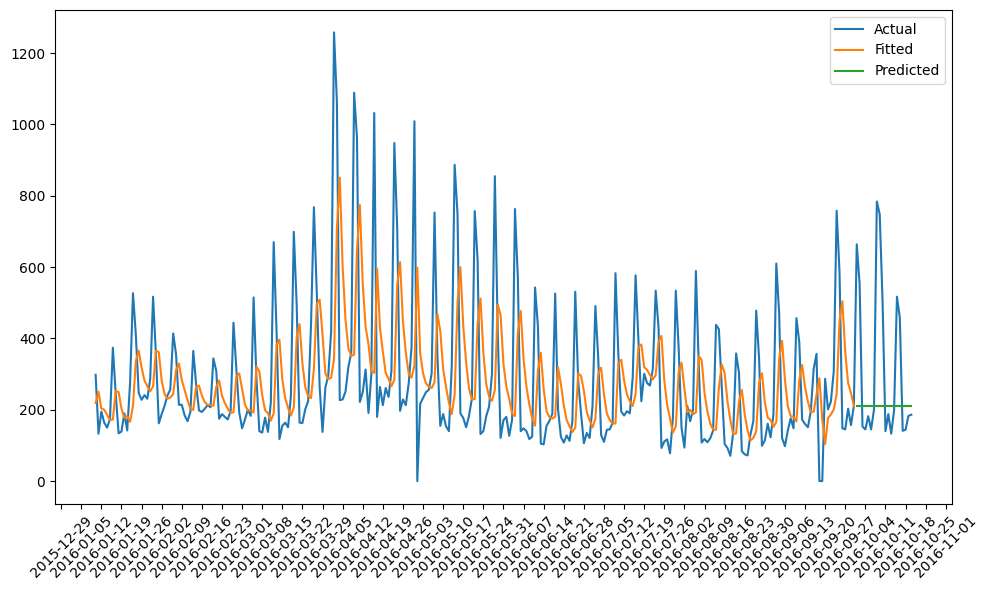

In [10]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plot the actual values, fitted values, and predicted values
plt.figure(figsize=(10, 6))  # Adjust the size of the plot as needed
plt.plot(ts_data_fill.index, ts_data_fill.values, label='Actual')
plt.plot(fitted_values.index, fitted_values.values, label='Fitted')
plt.plot(forecast.index, forecast.values, label='Predicted')

# Format the x-axis to display fewer labels
# For instance, show one label per week
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))  # Adjust interval as needed
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)  # Rotate the labels for better readability
plt.legend()
plt.tight_layout()  # Adjust the layout to fit everything nicely
plt.show()

## Model with trend

Double exponential smoothing, with additive trend.

In [11]:
# Run the model
# Specify the parameters for the exponential smoothing model
smoothing_level = 0.4
smoothing_slope = 0.3


# Fit a double exponential smoothing model to the data, including trend
model = sm.tsa.ExponentialSmoothing(train_data, trend='add')
fit_model = model.fit(smoothing_level=smoothing_level, smoothing_trend=smoothing_slope)
#fit_model = model.fit()

# Generate predictions for the next 21 days
forecast = fit_model.forecast(steps=20)

# Print the forecasted values
#print(forecast)

# Get the fitted values in Series format
fitted_values = fit_model.fittedvalues
# Get actual values in Series format
actual_values = data['Entry']

residual = actual_values - fitted_values

### Model fit

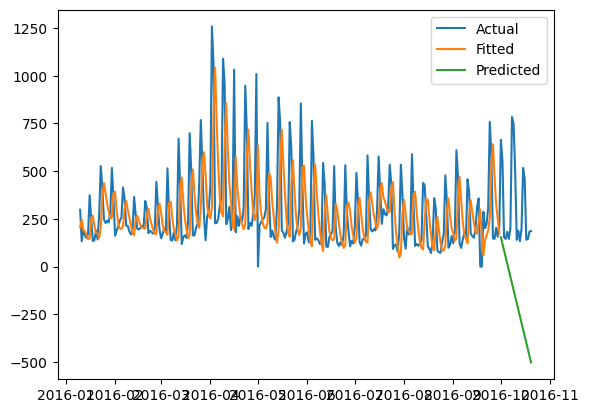

In [12]:
# Plot the actual values, fitted values, and predicted values
plt.plot(ts_data_fill.index, ts_data_fill.values, label='Actual')
plt.plot(fitted_values.index, fitted_values.values, label='Fitted')
plt.plot(forecast.index, forecast.values, label='Predicted')
plt.legend()
plt.show()

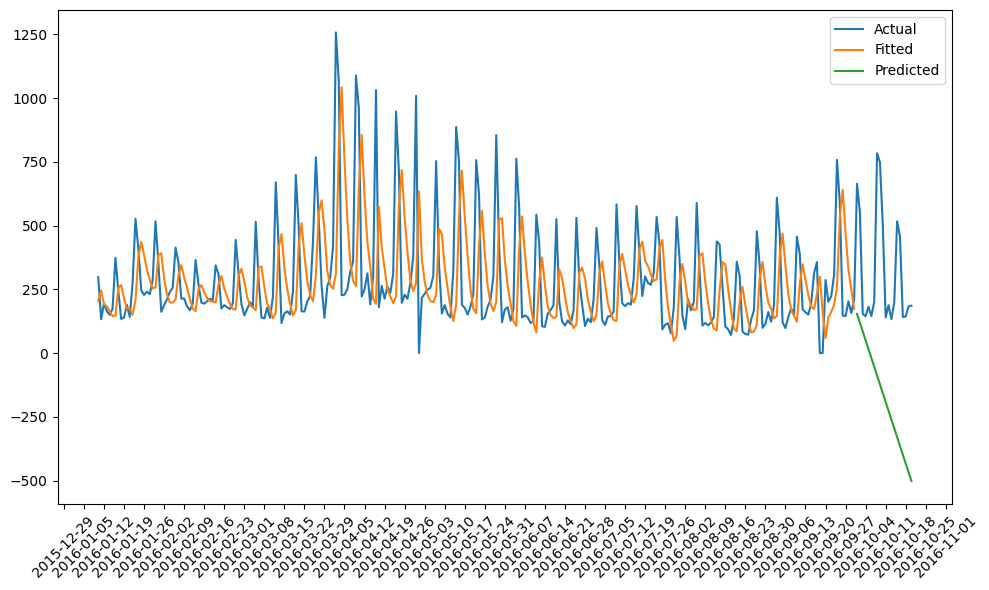

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plot the actual values, fitted values, and predicted values
plt.figure(figsize=(10, 6))  # Adjust the size of the plot as needed
plt.plot(ts_data_fill.index, ts_data_fill.values, label='Actual')
plt.plot(fitted_values.index, fitted_values.values, label='Fitted')
plt.plot(forecast.index, forecast.values, label='Predicted')

# Format the x-axis to display fewer labels
# For instance, show one label per week
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))  # Adjust interval as needed
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)  # Rotate the labels for better readability
plt.legend()
plt.tight_layout()  # Adjust the layout to fit everything nicely
plt.show()

## Model with seasonality

Consider now adding a 7 day seasonality to the model.

In [22]:
# Specify the parameters for the exponential smoothing model
smoothing_level = 0.4
smoothing_slope = 0.3
smoothing_season = 0.3

# Configuring the model to include weekly seasonality
# Additive
seasonal_model = sm.tsa.ExponentialSmoothing(train_data, trend='add', seasonal='add',seasonal_periods=7)
# Multiplicative
# seasonal_model = sm.tsa.ExponentialSmoothing(train_data, trend='add', seasonal='mul',
#                                       seasonal_periods=7)

#fit_seasonal_model = seasonal_model.fit(optimized=True)
fit_seasonal_model = seasonal_model.fit(smoothing_level=smoothing_level,
                                        smoothing_trend=smoothing_slope,
                                        smoothing_seasonal= smoothing_season)

# Display fitted parameters
# After fitting the model
alpha = fit_seasonal_model.params['smoothing_level']
beta = fit_seasonal_model.params.get('smoothing_trend', None)  # None if trend is not included
gamma = fit_seasonal_model.params.get('smoothing_seasonal', None)  # None if seasonality is not included

# Print the parameters
print(f"Optimized Alpha (Level Smoothing): {alpha}")
if beta is not None:
    print(f"Optimized Beta (Trend Smoothing): {beta}")
if gamma is not None:
    print(f"Optimized Gamma (Seasonal Smoothing): {gamma}")


# Forecasting from October 1 to October 20 with the seasonal model
forecast_start_date = '2016-10-01'
forecast_end_date = '2016-10-20'

# Generate predictions for the next 21 days
forecast_seasonal = fit_seasonal_model.forecast(steps=20)

# Print the forecasted values
print(forecast_seasonal)

Optimized Alpha (Level Smoothing): 0.4
Optimized Beta (Trend Smoothing): 0.3
Optimized Gamma (Seasonal Smoothing): 0.3
2016-10-01    458.647167
2016-10-02    232.545604
2016-10-03    -32.722171
2016-10-04     28.572356
2016-10-05     16.000242
2016-10-06    -13.916373
2016-10-07     16.515791
2016-10-08    269.616382
2016-10-09     43.514820
2016-10-10   -221.752955
2016-10-11   -160.458428
2016-10-12   -173.030543
2016-10-13   -202.947157
2016-10-14   -172.514993
2016-10-15     80.585598
2016-10-16   -145.515965
2016-10-17   -410.783740
2016-10-18   -349.489213
2016-10-19   -362.061327
2016-10-20   -391.977942
Freq: D, dtype: float64


Visualize the model fit in a time series graph

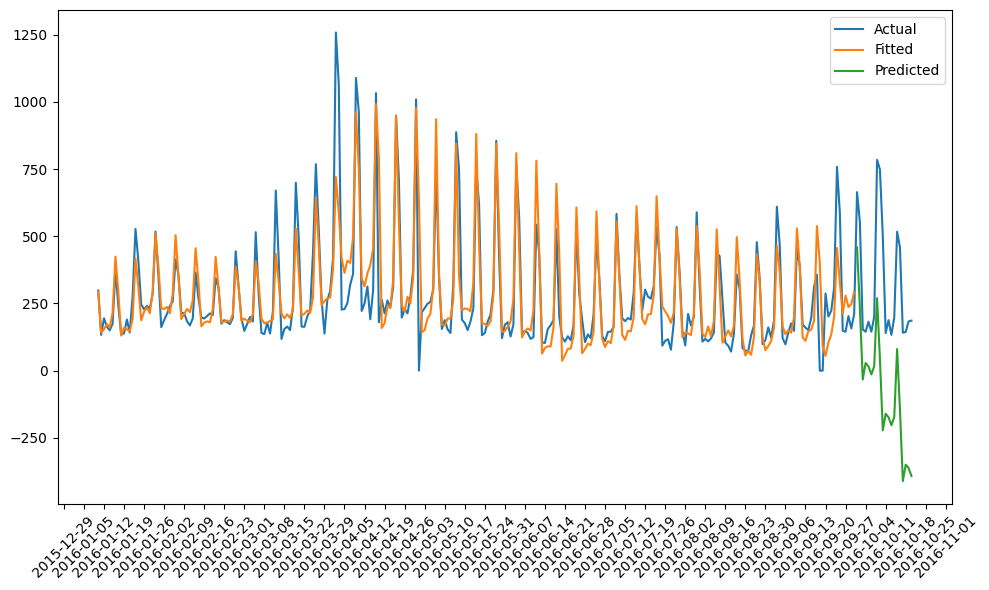

In [23]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plot the actual values, fitted values, and predicted values
plt.figure(figsize=(10, 6))  # Adjust the size of the plot as needed
plt.plot(ts_data_fill.index, ts_data_fill.values, label='Actual')
plt.plot(fitted_values.index, fitted_values.values, label='Fitted')
plt.plot(forecast_seasonal.index, forecast_seasonal.values, label='Predicted')

# Format the x-axis to display fewer labels
# For instance, show one label per week
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))  # Adjust interval as needed
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)  # Rotate the labels for better readability
plt.legend()
plt.tight_layout()  # Adjust the layout to fit everything nicely
plt.show()

### Optimize model parameters

Smoothing parameters are optimized to minimize in-sample residuals.

In [24]:
# Configuring the model to include weekly seasonality
seasonal_model = sm.tsa.ExponentialSmoothing(train_data, trend='add', seasonal='add',
                                      seasonal_periods=7)
fit_seasonal_model = seasonal_model.fit(optimized=True)


# Display fitted parameters
# After fitting the model
alpha = fit_seasonal_model.params['smoothing_level']
beta = fit_seasonal_model.params.get('smoothing_trend', None)  # None if trend is not included
gamma = fit_seasonal_model.params.get('smoothing_seasonal', None)  # None if seasonality is not included

# Print the parameters
print(f"Optimized Alpha (Level Smoothing): {alpha}")
if beta is not None:
    print(f"Optimized Beta (Trend Smoothing): {beta}")
if gamma is not None:
    print(f"Optimized Gamma (Seasonal Smoothing): {gamma}")


# Forecasting from October 1 to October 20 with the seasonal model
forecast_start_date = '2016-10-01'
forecast_end_date = '2016-10-20'

# Generate predictions for the next 21 days
forecast_seasonal = fit_seasonal_model.forecast(steps=20)

# Print the forecasted values
print(forecast_seasonal)

Optimized Alpha (Level Smoothing): 0.1484342519670551
Optimized Beta (Trend Smoothing): 0.02723868907392333
Optimized Gamma (Seasonal Smoothing): 0.2949567769219323
2016-10-01    579.124716
2016-10-02    392.899531
2016-10-03    141.138123
2016-10-04    196.097713
2016-10-05    202.266825
2016-10-06    200.468461
2016-10-07    285.782589
2016-10-08    584.170771
2016-10-09    397.945586
2016-10-10    146.184178
2016-10-11    201.143768
2016-10-12    207.312880
2016-10-13    205.514516
2016-10-14    290.828644
2016-10-15    589.216826
2016-10-16    402.991640
2016-10-17    151.230233
2016-10-18    206.189823
2016-10-19    212.358935
2016-10-20    210.560571
Freq: D, dtype: float64


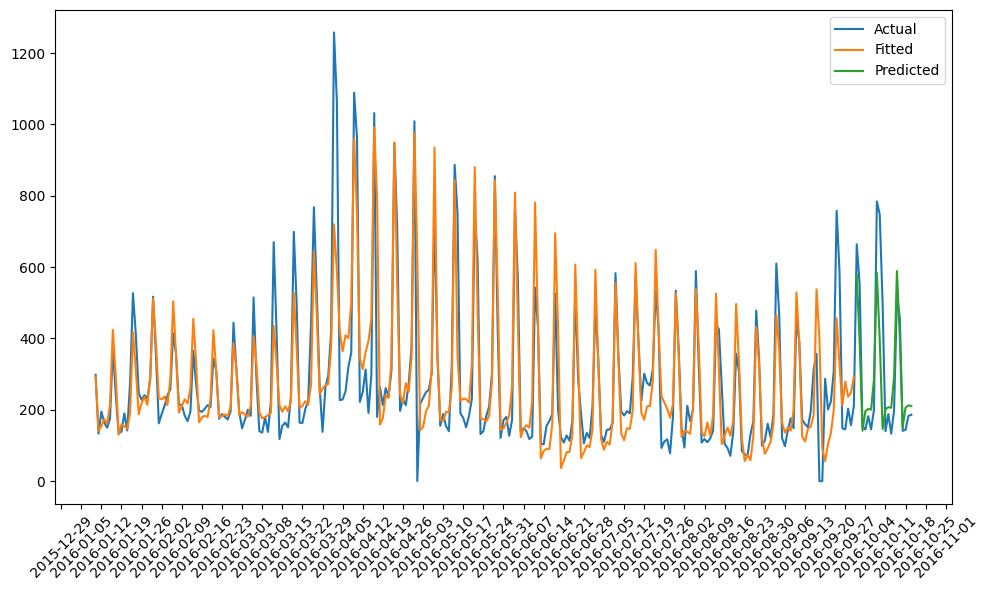

In [16]:
# Get the fitted values in Series format
fitted_values = fit_seasonal_model.fittedvalues

plt.figure(figsize=(10, 6))  # Adjust the size of the plot as needed

# Plot the actual values, fitted values, and predicted values
plt.plot(ts_data_fill.index, ts_data_fill.values, label='Actual')
plt.plot(fitted_values.index, fitted_values.values, label='Fitted')
plt.plot(forecast_seasonal.index, forecast_seasonal.values, label='Predicted')
plt.legend()

# Format the x-axis to display fewer labels
# For instance, show one label per week
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))  # Adjust interval as needed
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)  # Rotate the labels for better readability
plt.legend()
plt.tight_layout()  # Adjust the layout to fit everything nicely
plt.show()

## Forecast errors

We calculate the forecast errors in the training sample and out-of-sample predictions.

In [18]:
# Extracting the actual values for the forecasted period
# Ensure the index is sorted before slicing
ts_data_sorted = ts_data.sort_index()
actual_values = ts_data_sorted['2016-10-01':'2016-10-20']

# Calculating the residuals (actual - predicted)
residual_insample = train_data.values - fitted_values.values
residual_oos = actual_values - forecast_seasonal

# Printing the residuals
#print(residual_insample)

To measure the uncertainty of the forecasts, we examine the residuals, building a histogram. Comparing with the density function of the Normal distribution suggests this is a reasonable distribution to fit the data.

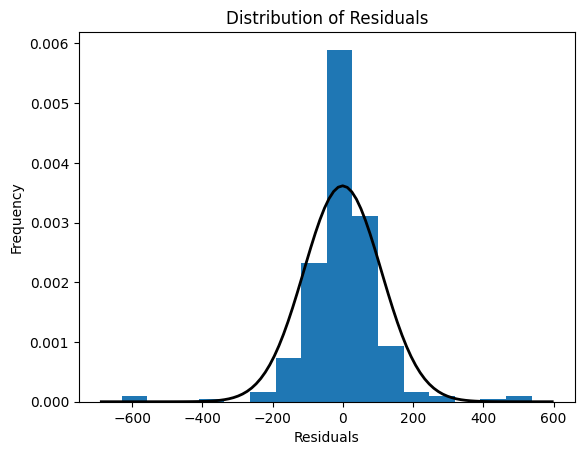

In [19]:
from scipy.stats import norm

# Draw a histogram of the residuals
# use Sturges formula to calculate number of bins

bins_sturges = int(np.sqrt(len(residual_insample)))

plt.hist(residual_insample, bins=bins_sturges, density=True)
#sns.histplot(resid, bins=range(165, 215, 5), kde=True, color='blue', edgecolor='black')

# create normal density curve to compare with histogram
mu,std = norm.fit(residual_insample)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

pcurve = norm.pdf(x, mu, std)

plt.plot(x, pcurve, 'k', linewidth=2)

plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

We calculate metric of fit: Mean Square Error and Mean Absolute Deviation

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Predicting the values for the training period using the fitted model
predicted_insample = fit_seasonal_model.fittedvalues

# Calculating the residuals (actual - predicted) for the training sample
residual_insample = train_data - predicted_insample

# Calculating Mean Squared Error (MSE)
mse = mean_squared_error(train_data, predicted_insample)

# Calculating Mean Absolute Error (MAE)
mae = mean_absolute_error(train_data, predicted_insample)

# Calculating Mean Absolute Percentage Error (MAPE)
#mape = np.mean(np.abs((train_data - predicted_insample) / train_data)) * 100
## MAPE not applicable here because there are 0's in the actual values

# Output results
print("Mean Squared Error:", mse)
print("Standard Error:", np.sqrt(mse))

print("Mean Absolute Deviation:", mae)

Mean Squared Error: 12172.82291033223
Standard Error: 110.33051667753682
Mean Absolute Deviation: 68.38667761312732
